In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian, plot_decision_boundary
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
from autograd import grad
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc
from sklearn.model_selection import train_test_split
from pandas import get_dummies

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

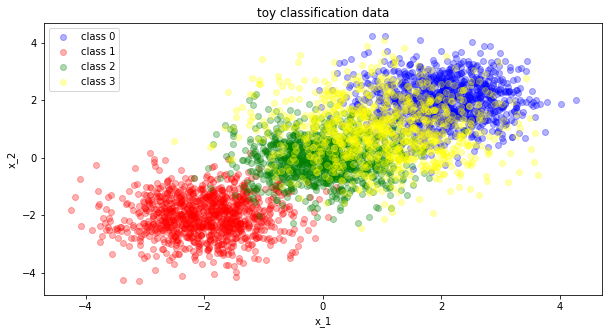

In [3]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, 1], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
x, y = two_clusters_gaussian(params, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 4 classes
* output dim = 4
* batch = 200

In [4]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nn.fit(X_train.T, y_train.T, params)

#print(y_)
#X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
#nlm.fit_MLE(X_train.T, y_train.T, params)

Iteration 0 lower bound 8.232378178742138; gradient mag: 2.6174911348238403
Iteration 100 lower bound 8.030684628194066; gradient mag: 0.1670446804342324
Iteration 200 lower bound 7.8728858340120045; gradient mag: 0.2843880137099083
Iteration 300 lower bound 7.7108136064152; gradient mag: 0.295775469453118
Iteration 400 lower bound 7.5174941942212925; gradient mag: 0.31271387304433307
Iteration 500 lower bound 7.313982867786646; gradient mag: 0.1511718039454418
Iteration 600 lower bound 7.266303099030206; gradient mag: 0.11208724409347069
Iteration 700 lower bound 7.23694041022988; gradient mag: 0.07964031466305412
Iteration 800 lower bound 7.216678814667699; gradient mag: 0.06473610397714538
Iteration 900 lower bound 7.202093006213852; gradient mag: 0.05499992843983211
Iteration 1000 lower bound 7.1899350757824685; gradient mag: 0.04957438797778881
Iteration 1100 lower bound 7.179805200506556; gradient mag: 0.04534142504319667
Iteration 1200 lower bound 7.171133490840602; gradient mag

Iteration 10200 lower bound 7.136748377066535; gradient mag: 0.006076834938021706
Iteration 10300 lower bound 7.136723887191049; gradient mag: 0.006106966382638046
Iteration 10400 lower bound 7.136700860754174; gradient mag: 0.0064150311389136044
Iteration 10500 lower bound 7.136667534548576; gradient mag: 0.00551236587904638
Iteration 10600 lower bound 7.136634508825848; gradient mag: 0.005950122630629666
Iteration 10700 lower bound 7.136597985482682; gradient mag: 0.005358513101769776
Iteration 10800 lower bound 7.136558117509837; gradient mag: 0.008160570236760114
Iteration 10900 lower bound 7.13650981063394; gradient mag: 0.010889775779512318
Iteration 11000 lower bound 7.136468224373558; gradient mag: 0.00568737619821515
Iteration 11100 lower bound 7.1364167716450995; gradient mag: 0.007645635253806103
Iteration 11200 lower bound 7.136363142678665; gradient mag: 0.010320379293191323
Iteration 11300 lower bound 7.136310314570437; gradient mag: 0.007992104754786757
Iteration 11400 l

In [6]:
#print(nn.forward(nn.weights,x.T)[0][0][:100],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][100:200],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][200:],'\n')
print(nn.forward(nn.weights,x.T))

[[2.14206075e-04 2.45135412e-55 4.00477617e-05 7.43170235e-04]
 [9.31753309e-04 3.64362236e-52 5.67378819e-08 5.76115517e-05]
 [9.70710078e-04 7.64481270e-53 5.68004466e-08 6.02919312e-05]
 ...
 [1.02744603e-04 1.08386789e-49 1.38302412e-04 7.50989848e-04]
 [1.78768736e-04 2.08618930e-55 5.82566791e-05 7.98255616e-04]
 [7.73898010e-05 1.34293216e-45 2.03573144e-04 6.88822789e-04]]


In [12]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, D_bayes)).T - (nn.forward(W, x.T)))**2, axis=1).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)

#log_likelihood(nn.weights)


IndexError: tuple index out of range

In [8]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def HMC_Unit_test():
    # Generate a toy dataset for classification
    samples = 100
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * 100 + [1] * 100)
    mean = np.zeros(3)
    cov = 10*np.eye(3)
    D = 3

    def log_likelihood(w):
        theta = sigmoid(w[-1] + np.dot(x, w[:-1]))
        return np.sum(np.log(theta[y==1])) + np.sum(np.log(1 - theta[y==0]))

    def log_normal_prior(W):
        logprior = -0.5 * (np.log(np.linalg.det(cov)) + D * np.log(2 * np.pi))
        logprior += -0.5 * np.dot(np.dot(W-mean, np.linalg.inv(cov)), (W-mean).T)
        return logprior
    
    log_prior = log_normal_prior
    log_likelihood = log_likelihood
    lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    lr.fit(x, y)
    position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
    position_init = position_init.reshape((1, 3))[0]
    samples = hmc(log_prior, log_likelihood, 1000,  1e-1, 20, position_init, 0.1, 1)
    q_=np.asarray(samples).T
    plt.plot(range(len(q_[0])),q_[0] , color='r')
    plt.title('BNN posterior')
    plt.show()
    #print(log_likelihood(position_init))


In [9]:
HMC_Unit_test()

2.835323670700972
0.34161401086539617
1.1698762302675996
4.138589125605994
0.24999946931846495
0.47845175061588596
0.07299327088287241
2.1648795172647666
0.5134636097849267
1.1238711993785475
0.4192351954922791
1.2988531581009541
1.357625218651709
0.160027572332946
1.1970215494474408
1.1286246849774926
1.6908069959167598
0.42639213789115143
0.7758753858080525
1.1216608975959397
0.6977391345931316
0.7180550440017497
0.35544624429839955
0.6265064329923169
1.0332368391564501
2.7934225724916724
0.2705106506090892
0.9383295804422667
0.3081201626167689
0.77773637944762
1.3008819735431372
0.06237662938062186
0.6250119480427146
1.293942851828109
0.851531611431395
0.4265249273693704
1.0816748373275467
0.9351668981696284
1.5141548389821284
0.3295473975767869
0.11193525450483988
0.4496511039195373
0.8525949902388761
1.4929753924545248
1.097590884070296
1.0613629019672657
0.837991878906142
0.9873127665666418
0.7376017892750374
1.122512500110064
0.4208299361536012
1.3257533332463856
1.9928260223470

KeyboardInterrupt: 

In [7]:
q_=np.asarray(samples).T
plt.plot(range(len(q_[0])),q_[0] , color='r')
plt.title('BNN posterior')
plt.show()

NameError: name 'samples' is not defined

120
(14400, 2)
(92,)


ValueError: cannot reshape array of size 43200 into shape (120,120)

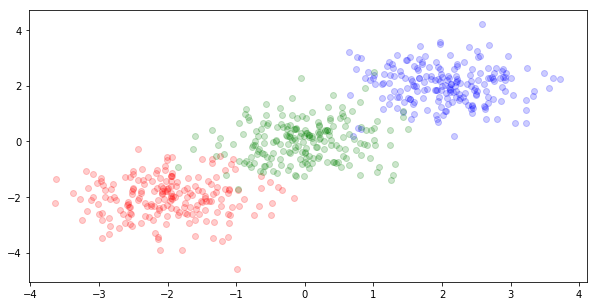

In [27]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn.weights[0][-1],nn.weights[0][:-1],nn.forward,nn.weights)
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# NLM

In [10]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [11]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)


y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

Iteration 0 lower bound 1.7465503002038252; gradient mag: 1.8865744553956802
Iteration 100 lower bound 1.523237253355977; gradient mag: 0.47916832969423173
Iteration 200 lower bound 1.250577090862505; gradient mag: 0.4337023011683368
Iteration 300 lower bound 0.9325462588331481; gradient mag: 0.4348400398070645
Iteration 400 lower bound 0.7052796963921097; gradient mag: 0.27698017279363074
Iteration 500 lower bound 0.5972731922368719; gradient mag: 0.18165189569491427
Iteration 600 lower bound 0.5401033277342695; gradient mag: 0.13751699038668744
Iteration 700 lower bound 0.5036645365343444; gradient mag: 0.0993638278460291
Iteration 800 lower bound 0.4831831084870965; gradient mag: 0.06896853217059022
Iteration 900 lower bound 0.4753201359592027; gradient mag: 0.04562177451956744
Iteration 1000 lower bound 0.47195726938077615; gradient mag: 0.027125241198916284
Iteration 1100 lower bound 0.4703049318415405; gradient mag: 0.0269177590106838
Iteration 1200 lower bound 0.4689685820968352

Iteration 10100 lower bound 0.45543018035612237; gradient mag: 0.045637466106195825
Iteration 10200 lower bound 0.4554146406572578; gradient mag: 0.028094589509052855
Iteration 10300 lower bound 0.45540995765423603; gradient mag: 0.047591211514071044
Iteration 10400 lower bound 0.4553970669287095; gradient mag: 0.029629980786969237
Iteration 10500 lower bound 0.45538418743954423; gradient mag: 0.013045096902679321
Iteration 10600 lower bound 0.4553737258300379; gradient mag: 0.024887645729824406
Iteration 10700 lower bound 0.4553615510484084; gradient mag: 0.041316567598646575
Iteration 10800 lower bound 0.45534723038818953; gradient mag: 0.030108394373388987
Iteration 10900 lower bound 0.4553402432830357; gradient mag: 0.022806033383597792
Iteration 11000 lower bound 0.4553482814560177; gradient mag: 0.04786842656995176
Iteration 11100 lower bound 0.45532386778396694; gradient mag: 0.02246394842140188
Iteration 11200 lower bound 0.4553108121802151; gradient mag: 0.013250487027420085
I

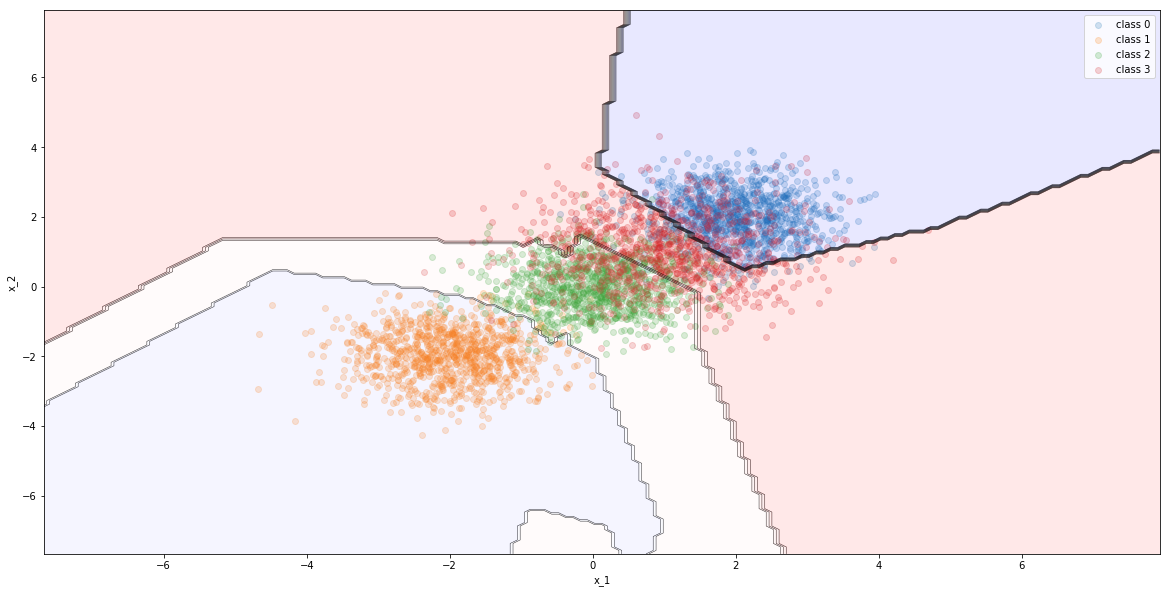

In [12]:
classifier = [Classifier(nlm.weights, nlm.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, classifier, ax)
plt.show()

In [17]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

#sigmoid_probability=nlm.forward(nlm.weights, x.T)
#sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
#bce = np.dot(np.log(sigmoid_probability),y.flatten())
#bce1 = sum([np.dot(np.log(sigmoid_probability)[:,:,i],y.flatten()[i]) for i in range(len(y.flatten()))])
#-sum([p[i]*log2(q[i]) for i in range(len(p))])
#print(bce,'\n',bce1)


nlm.forward(nlm.weights,x.T).shape


(4000, 4)

In [18]:
print(nlm.weights)
nlm.fit_NLM(x.T, y.reshape(1,-1),hmc,params_hmc)

[[ 1.72498663  0.2055907   0.57118473  0.42431817  1.97018417 -0.41926795
   1.23475955 -0.07985082 -0.64755823  0.53287767  1.06408124  2.34971722
   1.23971867  0.57830008  1.0709556   0.25745403  1.3914724  -0.74884999
   0.22855753 -0.8697386  -3.36423797 -0.10799488  1.02769984 -1.92479863
   1.46714059 -5.77708555 -1.18259771 -0.70150003  1.29462217  1.36946631
   0.22432362  0.27323446 -1.04014321 -2.3695494  -0.91147366  0.43431882
   1.2944919   0.919669   -1.22567693  1.17574308 -1.18827988 -0.51103635
   0.3493508   1.4101647  -1.58509425 -0.97044177 -0.98987544  0.34593027
  -4.51557028  0.34877728 -0.61180256  0.54540537  0.33492681  1.74226584
  -0.00993965  0.23743312 -0.11893141  0.41293176 -0.11408628 -0.49697948
  -0.89543647  0.07881674 -0.17659801  0.66181996  1.03446629 -0.03672571
  -0.87401336  1.01936603  0.40177383 -0.30715277  0.01662562  2.17193587
   2.09884151 -2.54082992  2.03128128 -1.59486196 -0.87013871 -1.98068692
   0.56759198 -1.90050926 -5.52966234 

ValueError: shapes (1,99) and (1,5,4000) not aligned: 99 (dim 1) != 5 (dim 1)